In [137]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from math import sin, cos, sqrt, atan2, radians
import datetime

# Загружаем данные

In [138]:
train = pd.read_csv('train.csv')
train.head()

,cancel_time,driver_found,due,f_class,lat,lon,s_class,t_class,burned
0,55,False,2014-01-01 00:09:32.000,econom,55.750130,37.823242,NaN,NaN,True
1,-1,True,2014-01-01 00:09:32.000,econom,55.750130,37.823242,NaN,NaN,False
2,-1,True,2014-01-01 00:10:00.000,econom,55.651582,37.340891,NaN,NaN,False
3,-1,True,2014-01-01 00:10:00.000,econom,55.633404,37.797595,NaN,NaN,False
4,-1,True,2014-01-01 00:10:00.000,econom,55.770330,37.519917,NaN,NaN,False


In [139]:
test = pd.read_csv('test.csv')
test.head()

,due,f_class,lat,lon,s_class,t_class
1449959,2014-03-15 12:40:00.000,econom,55.612065,37.760539,NaN,NaN
1449941,2014-03-15 12:40:00.000,econom,55.784369,37.672244,business,NaN
1449961,2014-03-15 12:40:00.000,econom,55.716803,37.422776,NaN,NaN
1449960,2014-03-15 12:40:00.000,econom,55.791430,37.472090,NaN,NaN
1449978,2014-03-15 12:40:00.000,econom,59.845695,30.371014,NaN,NaN


In [140]:
train=train.drop(['cancel_time','driver_found'],axis=1)
train.head()

,due,f_class,lat,lon,s_class,t_class,burned
0,2014-01-01 00:09:32.000,econom,55.750130,37.823242,NaN,NaN,True
1,2014-01-01 00:09:32.000,econom,55.750130,37.823242,NaN,NaN,False
2,2014-01-01 00:10:00.000,econom,55.651582,37.340891,NaN,NaN,False
3,2014-01-01 00:10:00.000,econom,55.633404,37.797595,NaN,NaN,False
4,2014-01-01 00:10:00.000,econom,55.770330,37.519917,NaN,NaN,False


# Готовим фичи и фитим модель

In [141]:
train['burned']=np.where(train['burned']==True,1,0)
y=train[['burned']]

In [142]:
train['burned'].value_counts()

0    1212757
1     237243
Name: burned, dtype: int64

**Местоположение машины:**

In [100]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

train[['lat','lon']]=ss.fit_transform(train[['lat','lon']])

Distance=train[train.columns[pd.Series(train.columns).str.startswith('Distance')]]
train[train.columns[pd.Series(train.columns).str.startswith('Distance')]]=ss.fit_transform(Distance)

train['cossin']=np.cos(train['lon'])*np.sin(train['lat'])
train['sincos']=np.sin(train['lon'])*np.cos(train['lat'])
train['cos']=np.cos(train['lat'])

**Близость аэропортов и вокзалов:**

Коориданты аэропортов:

In [93]:
#Домодедово
DMElat = 55.4086110
DMElon = 37.9061110
#Шереметьвево
SVOlat = 55.9727780
SVOlon = 37.4147220
#Внуково
VKOlat = 55.6031500
VKOlon = 37.2921000
#Пулково
PLlat = 59.7998772
PLlon = 30.2733421

Координаты вокзалов:

In [94]:
#Белорусский
BELlat = 55.7768974
BELlon = 37.5813255
#Ленинградский 
LENlat = 55.7765312
LENlon = 37.6551781
#Ярославский
YRlat = 55.7770042
YRlon = 37.6571884
#Казанский
KZlat = 55.7737923
KZlon = 37.6570778
#Киевский
KVlat = 55.7432632
KVlon = 37.5665741
#Курский
KRlat = 55.7576218 
KRlon = 37.6607666
#Павелецкий 
PVLlat = 55.7298279
PVLlon = 37.6389351
#Рижский
RJlat = 55.792609
RJlon = 37.632615
#Савеловский
SVLlat = 55.793738
SVLlon = 37.587865
#Витебский 
VTBlat = 59.9199219
VTBlon = 30.3288956
#Ладожский
LDlat = 59.9317513
LDlon = 30.4410629
#Московский
MSKlat = 59.929996 
MSKlon = 30.362145
#Финский
FINlat = 59.955641
FINlon = 30.356502
#Балтийский
BLlat = 59.907115
BLlon = 30.298882

Столько составляет 1 км и 300 м в наших условных единицах:

In [95]:
a = 55.609655
b = 37.303817
km =((a - VKOlat)**2 + (b - VKOlon)**2)**0.5
m = km*400/1000
print(km)#1 км
print(m)#300 м 

0.013401608634789548
0.005360643453915819


Расстояние от точки вызыва такси до аэропорта:

In [96]:
train['DistanceToDME'] = ((train['lat'] - DMElat)**2 + (train['lon'] - DMElon)**2)**0.5
train['DistanceToSVO'] =((train['lat'] - SVOlat)**2 + (train['lon'] - SVOlon)**2)**0.5
train['DistanceToVKO'] =((train['lat'] - VKOlat)**2 + (train['lon'] - VKOlon)**2)**0.5
train['DistanceToPL'] = ((train['lat'] - PLlat)**2 + (train['lon'] - PLlon)**2)**0.5

Близость к аэропортам:

In [97]:
train['Airports'] = np.where(
    (train['DistanceToDME']<=km) | \
    (train['DistanceToSVO']<=km) | \
    (train['DistanceToVKO']<=km) | \
    (train['DistanceToPL']<=km),
    1,0)

Расстояние от точки вызыва такси до вокзала:

In [98]:
train['DistanceToBEL'] = ((train['lat'] - BELlat)**2 + (train['lon'] - BELlon)**2)**0.5
train['DistanceToLEN'] = ((train['lat'] - LENlat)**2 + (train['lon'] - LENlon)**2)**0.5
train['DistanceToYR'] = ((train['lat'] - YRlat)**2 + (train['lon'] - YRlon)**2)**0.5
train['DistanceToKZ'] = ((train['lat'] - KZlat)**2 + (train['lon'] - KZlon)**2)**0.5
train['DistanceToKV'] = ((train['lat'] - KVlat)**2 + (train['lon'] - KVlon)**2)**0.5
train['DistanceToKR'] = ((train['lat'] - KRlat)**2 + (train['lon'] - KRlon)**2)**0.5
train['DistanceToPVL'] = ((train['lat'] - PVLlat)**2 + (train['lon'] - PVLlon)**2)**0.5
train['DistanceToRJ'] = ((train['lat'] - RJlat)**2 + (train['lon'] - RJlon)**2)**0.5
train['DistanceToSVL'] = ((train['lat'] - SVLlat)**2 + (train['lon'] - SVLlon)**2)**0.5
train['DistanceToVTB'] = ((train['lat'] - VTBlat)**2 + (train['lon'] - VTBlon)**2)**0.5
train['DistanceToLD'] = ((train['lat'] - LDlat)**2 + (train['lon'] - LDlon)**2)**0.5
train['DistanceToMSK'] = ((train['lat'] - MSKlat)**2 + (train['lon'] - MSKlon)**2)**0.5
train['DistanceToFIN'] = ((train['lat'] - FINlat)**2 + (train['lon'] - FINlon)**2)**0.5
train['DistanceToBL'] = ((train['lat'] - BLlat)**2 + (train['lon'] - BLlon)**2)**0.5

Близость к вокзалам:

In [99]:
train['Railway_station'] = np.where((
    train['DistanceToBEL']<=m) | \
    (train['DistanceToLEN']<=m) | \
    (train['DistanceToYR']<=m) | \
    (train['DistanceToKZ']<=m) | \
    (train['DistanceToKV']<=m) | \
    (train['DistanceToKR']<=m) | \
    (train['DistanceToPVL']<=m) | \
    (train['DistanceToRJ']<=m) | \
    (train['DistanceToSVL']<=m) | \
    (train['DistanceToBL']<=m) | \
    (train['DistanceToFIN']<=m) | \
    (train['DistanceToMSK']<=m) | \
    (train['DistanceToLD']<=m) | \
    (train['DistanceToVTB']<=m), \
    1,0)


#### **Выходной/Будний и время суток:**

In [122]:
train['data'], train['time'] = train['due'].str.split(' ', 1).str

Время суток:

In [123]:
train['Morning'] =np.where((train['time']>='04:00:00.000') & (train['time']<= '11:59:59.999'),1,0)
train['Day'] =np.where((train['time']>='12:00:00.000') & (train['time']<= '16:59:59.999'),1,0)
train['Evening'] =np.where((train['time']>='17:00:00.000') & (train['time']<= '23:59:59.999'),1,0)
train['Night'] =np.where((train['time']>='00:00:00.000') & (train['time']<= '03:59:59.999'),1,0)

День недели:

In [124]:
train['data'] = pd.to_datetime(train['data'])
train['dow']=train['data'].dt.dayofweek
train['working_day'] = np.where((train['dow']<5),1,0)

train=pd.concat([train,pd.get_dummies(train['dow'].astype(object)).add_prefix('dow_')],axis=1)                                                                                              

Пиковые нагрузки:

In [125]:
train['peaktime_1'] = np.where(
    ((train['time']>='08:00:00.000') & (train['time']<= '10:00:00.000')),
    1,0
    )
train['peaktime_2'] = np.where(
    ((train['time']>='17:45:00.000') & (train['time']<= '20:00:00.000')),
    1,0
    )

Часы:

In [126]:
train['hour'] = pd.to_datetime(train['time'].astype(str)).dt.hour
train=pd.concat([train,pd.get_dummies(train['hour'].astype(object)).add_prefix('hour_')],axis=1)

In [127]:
train['56'] = np.where((train['hour']== 5) | (train['hour']== 6), 1, 0)
train['68'] = np.where((train['hour']== 7) | (train['hour']== 8), 1, 0)
train['910'] = np.where((train['hour']== 9) | (train['hour']== 10), 1, 0)
train['1516'] = np.where((train['hour']== 15) | (train['hour']== 16), 1, 0)
train['1213'] = np.where((train['hour']== 12) | (train['hour']== 13), 1, 0)
train['1819'] = np.where((train['hour']== 18) | (train['hour']== 19), 1, 0)
train['202122'] = np.where((train['hour']== 20) | (train['hour']== 21) | (train['hour']==22), 1, 0)
train['2301'] = np.where((train['hour']== 23) | (train['hour']== 0) | (train['hour']==1), 1, 0)

In [128]:
train['day'] = pd.to_datetime(train['data'].astype(str)).dt.day
train=pd.concat([train,pd.get_dummies(train['day'].astype(object)).add_prefix('day_')],axis=1)

**Класс автомобиля:**

In [143]:
train[['f_class','s_class','t_class']]=train[['f_class','s_class','t_class']].fillna('nan')

Закодируем качественные переменные:

In [144]:
X_dummy=pd.get_dummies(X)

X_dummy['f_max']=3*X_dummy['f_class_vip']+2*X_dummy['f_class_business']+1*X_dummy['f_class_econom']
X_dummy['s_max']=3*X_dummy['s_class_vip']+2*X_dummy['s_class_business']+1*X_dummy['s_class_econom']
X_dummy['t_max']=3*X_dummy['t_class_vip']+2*X_dummy['t_class_business']+1*X_dummy['t_class_econom']
X_dummy['max']=np.max(np.array([X_dummy['f_max'].values,X_dummy['s_max'].values,X_dummy['t_max'].values]).T,axis=1)

y=y.values.ravel()

**Ложные заказы:**

In [151]:
train['fraud']=train.duplicated(subset=['lat', 'lon', 'due'], keep=False)
train['fraud'] = np.where(train['fraud']==True, 1, 0)

Удаляем лишнее:

In [66]:
drop=['due','burned','data','time',
      'dow',
      'hour','day',
'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'day_7',
 'day_8',
 'day_9',
 'day_10',
 'day_11',
 'day_12',
 'day_13',
 'day_14']

train=train.drop(drop,axis=1)
X=train.copy()

Получаем следующие признаки:

In [136]:
X_dummy.columns.tolist()

['lat',
 'lon',
 'DistanceToDME',
 'DistanceToSVO',
 'DistanceToVKO',
 'DistanceToPL',
 'Airports',
 'DistanceToBEL',
 'DistanceToLEN',
 'DistanceToYR',
 'DistanceToKZ',
 'DistanceToKV',
 'DistanceToKR',
 'DistanceToPVL',
 'DistanceToRJ',
 'DistanceToSVL',
 'DistanceToVTB',
 'DistanceToLD',
 'DistanceToMSK',
 'DistanceToFIN',
 'DistanceToBL',
 'Railway_station',
 'cossin',
 'sincos',
 'cos',
 'Morning',
 'Day',
 'Evening',
 'Night',
 'working_day',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5',
 'dow_6',
 'peaktime_1',
 'peaktime_2',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 '56',
 '68',
 '910',
 '1516',
 '1213',
 '1819',
 '202122',
 '2301',
 'day_15',
 'day_16',
 'day_17',
 'day_18',
 'day_19',
 'day_20',
 'day_21',
 'day_22',
 'day_23',
 

**Фитим модель**

In [69]:
from sklearn.linear_model import LogisticRegression
log=LogisticRegression()
log.fit(X_dummy,y)
roc_auc_score(y, log.predict_proba(X_dummy)[:, 1])

0.6760749089280566

In [70]:
#!pip install catboost
from catboost import CatBoostClassifier
cat=CatBoostClassifier()
cat.fit(X=X_dummy,y=y)

0:	learn: 0.6141040	total: 883ms	remaining: 14m 42s
1:	learn: 0.5572346	total: 1.69s	remaining: 14m 2s
2:	learn: 0.5164011	total: 2.55s	remaining: 14m 6s
3:	learn: 0.4871599	total: 3.33s	remaining: 13m 48s
4:	learn: 0.4658140	total: 4.29s	remaining: 14m 14s
5:	learn: 0.4504198	total: 5.07s	remaining: 14m
6:	learn: 0.4393376	total: 5.88s	remaining: 13m 54s
7:	learn: 0.4311095	total: 6.64s	remaining: 13m 43s
8:	learn: 0.4250265	total: 7.41s	remaining: 13m 35s
9:	learn: 0.4202597	total: 8.26s	remaining: 13m 37s
10:	learn: 0.4168105	total: 9.14s	remaining: 13m 41s
11:	learn: 0.4141883	total: 9.9s	remaining: 13m 35s
12:	learn: 0.4121987	total: 10.7s	remaining: 13m 32s
13:	learn: 0.4106295	total: 11.5s	remaining: 13m 30s
14:	learn: 0.4095002	total: 12.5s	remaining: 13m 43s
15:	learn: 0.4085621	total: 13.4s	remaining: 13m 43s
16:	learn: 0.4078863	total: 14.1s	remaining: 13m 35s
17:	learn: 0.4072437	total: 14.9s	remaining: 13m 30s
18:	learn: 0.4067818	total: 15.5s	remaining: 13m 22s
19:	learn:

154:	learn: 0.4001724	total: 1m 59s	remaining: 10m 50s
155:	learn: 0.4001609	total: 2m	remaining: 10m 49s
156:	learn: 0.4001485	total: 2m	remaining: 10m 48s
157:	learn: 0.4001320	total: 2m 1s	remaining: 10m 48s
158:	learn: 0.4001176	total: 2m 2s	remaining: 10m 48s
159:	learn: 0.4001069	total: 2m 3s	remaining: 10m 46s
160:	learn: 0.4000865	total: 2m 3s	remaining: 10m 45s
161:	learn: 0.4000647	total: 2m 4s	remaining: 10m 44s
162:	learn: 0.4000522	total: 2m 5s	remaining: 10m 43s
163:	learn: 0.4000249	total: 2m 6s	remaining: 10m 44s
164:	learn: 0.4000085	total: 2m 7s	remaining: 10m 43s
165:	learn: 0.3999924	total: 2m 7s	remaining: 10m 42s
166:	learn: 0.3999792	total: 2m 8s	remaining: 10m 41s
167:	learn: 0.3999676	total: 2m 9s	remaining: 10m 40s
168:	learn: 0.3999438	total: 2m 10s	remaining: 10m 40s
169:	learn: 0.3999186	total: 2m 11s	remaining: 10m 40s
170:	learn: 0.3999072	total: 2m 11s	remaining: 10m 38s
171:	learn: 0.3998885	total: 2m 12s	remaining: 10m 37s
172:	learn: 0.3998811	total: 

306:	learn: 0.3980677	total: 4m 6s	remaining: 9m 16s
307:	learn: 0.3980588	total: 4m 7s	remaining: 9m 15s
308:	learn: 0.3980503	total: 4m 8s	remaining: 9m 14s
309:	learn: 0.3980360	total: 4m 8s	remaining: 9m 13s
310:	learn: 0.3980127	total: 4m 9s	remaining: 9m 13s
311:	learn: 0.3980007	total: 4m 10s	remaining: 9m 12s
312:	learn: 0.3979923	total: 4m 11s	remaining: 9m 11s
313:	learn: 0.3979792	total: 4m 12s	remaining: 9m 10s
314:	learn: 0.3979627	total: 4m 12s	remaining: 9m 9s
315:	learn: 0.3979563	total: 4m 13s	remaining: 9m 8s
316:	learn: 0.3979454	total: 4m 14s	remaining: 9m 7s
317:	learn: 0.3979338	total: 4m 14s	remaining: 9m 6s
318:	learn: 0.3979177	total: 4m 15s	remaining: 9m 6s
319:	learn: 0.3979052	total: 4m 16s	remaining: 9m 5s
320:	learn: 0.3978945	total: 4m 17s	remaining: 9m 4s
321:	learn: 0.3978794	total: 4m 18s	remaining: 9m 4s
322:	learn: 0.3978610	total: 4m 19s	remaining: 9m 3s
323:	learn: 0.3978529	total: 4m 19s	remaining: 9m 2s
324:	learn: 0.3978287	total: 4m 20s	remaini

459:	learn: 0.3965322	total: 6m 7s	remaining: 7m 11s
460:	learn: 0.3965234	total: 6m 8s	remaining: 7m 10s
461:	learn: 0.3965158	total: 6m 9s	remaining: 7m 9s
462:	learn: 0.3965011	total: 6m 10s	remaining: 7m 9s
463:	learn: 0.3964875	total: 6m 10s	remaining: 7m 8s
464:	learn: 0.3964748	total: 6m 11s	remaining: 7m 7s
465:	learn: 0.3964702	total: 6m 12s	remaining: 7m 6s
466:	learn: 0.3964607	total: 6m 13s	remaining: 7m 5s
467:	learn: 0.3964530	total: 6m 14s	remaining: 7m 5s
468:	learn: 0.3964424	total: 6m 14s	remaining: 7m 4s
469:	learn: 0.3964354	total: 6m 15s	remaining: 7m 3s
470:	learn: 0.3964308	total: 6m 16s	remaining: 7m 2s
471:	learn: 0.3964174	total: 6m 17s	remaining: 7m 2s
472:	learn: 0.3964111	total: 6m 17s	remaining: 7m 1s
473:	learn: 0.3963957	total: 6m 18s	remaining: 7m
474:	learn: 0.3963866	total: 6m 19s	remaining: 6m 59s
475:	learn: 0.3963752	total: 6m 20s	remaining: 6m 58s
476:	learn: 0.3963662	total: 6m 21s	remaining: 6m 57s
477:	learn: 0.3963545	total: 6m 21s	remaining: 

612:	learn: 0.3951845	total: 8m 13s	remaining: 5m 11s
613:	learn: 0.3951745	total: 8m 14s	remaining: 5m 10s
614:	learn: 0.3951676	total: 8m 15s	remaining: 5m 10s
615:	learn: 0.3951597	total: 8m 16s	remaining: 5m 9s
616:	learn: 0.3951509	total: 8m 16s	remaining: 5m 8s
617:	learn: 0.3951428	total: 8m 17s	remaining: 5m 7s
618:	learn: 0.3951293	total: 8m 18s	remaining: 5m 6s
619:	learn: 0.3951172	total: 8m 19s	remaining: 5m 6s
620:	learn: 0.3951108	total: 8m 20s	remaining: 5m 5s
621:	learn: 0.3951038	total: 8m 20s	remaining: 5m 4s
622:	learn: 0.3950974	total: 8m 21s	remaining: 5m 3s
623:	learn: 0.3950874	total: 8m 22s	remaining: 5m 2s
624:	learn: 0.3950789	total: 8m 23s	remaining: 5m 1s
625:	learn: 0.3950733	total: 8m 23s	remaining: 5m
626:	learn: 0.3950658	total: 8m 24s	remaining: 5m
627:	learn: 0.3950628	total: 8m 25s	remaining: 4m 59s
628:	learn: 0.3950571	total: 8m 25s	remaining: 4m 58s
629:	learn: 0.3950434	total: 8m 26s	remaining: 4m 57s
630:	learn: 0.3950352	total: 8m 27s	remaining:

765:	learn: 0.3940501	total: 10m 24s	remaining: 3m 10s
766:	learn: 0.3940439	total: 10m 25s	remaining: 3m 9s
767:	learn: 0.3940375	total: 10m 26s	remaining: 3m 9s
768:	learn: 0.3940278	total: 10m 26s	remaining: 3m 8s
769:	learn: 0.3940224	total: 10m 27s	remaining: 3m 7s
770:	learn: 0.3940164	total: 10m 28s	remaining: 3m 6s
771:	learn: 0.3940098	total: 10m 29s	remaining: 3m 5s
772:	learn: 0.3940021	total: 10m 30s	remaining: 3m 5s
773:	learn: 0.3939927	total: 10m 30s	remaining: 3m 4s
774:	learn: 0.3939892	total: 10m 31s	remaining: 3m 3s
775:	learn: 0.3939820	total: 10m 32s	remaining: 3m 2s
776:	learn: 0.3939792	total: 10m 33s	remaining: 3m 1s
777:	learn: 0.3939742	total: 10m 34s	remaining: 3m
778:	learn: 0.3939662	total: 10m 34s	remaining: 3m
779:	learn: 0.3939592	total: 10m 35s	remaining: 2m 59s
780:	learn: 0.3939496	total: 10m 37s	remaining: 2m 58s
781:	learn: 0.3939450	total: 10m 38s	remaining: 2m 57s
782:	learn: 0.3939404	total: 10m 39s	remaining: 2m 57s
783:	learn: 0.3939335	total: 

916:	learn: 0.3930676	total: 12m 26s	remaining: 1m 7s
917:	learn: 0.3930625	total: 12m 27s	remaining: 1m 6s
918:	learn: 0.3930543	total: 12m 28s	remaining: 1m 6s
919:	learn: 0.3930495	total: 12m 29s	remaining: 1m 5s
920:	learn: 0.3930438	total: 12m 30s	remaining: 1m 4s
921:	learn: 0.3930382	total: 12m 31s	remaining: 1m 3s
922:	learn: 0.3930320	total: 12m 32s	remaining: 1m 2s
923:	learn: 0.3930245	total: 12m 32s	remaining: 1m 1s
924:	learn: 0.3930177	total: 12m 33s	remaining: 1m 1s
925:	learn: 0.3930115	total: 12m 34s	remaining: 1m
926:	learn: 0.3930076	total: 12m 35s	remaining: 59.5s
927:	learn: 0.3929999	total: 12m 35s	remaining: 58.7s
928:	learn: 0.3929980	total: 12m 36s	remaining: 57.8s
929:	learn: 0.3929936	total: 12m 37s	remaining: 57s
930:	learn: 0.3929825	total: 12m 38s	remaining: 56.2s
931:	learn: 0.3929751	total: 12m 39s	remaining: 55.4s
932:	learn: 0.3929697	total: 12m 39s	remaining: 54.6s
933:	learn: 0.3929624	total: 12m 40s	remaining: 53.7s
934:	learn: 0.3929527	total: 12m 

In [71]:
roc_auc_score(y, cat.predict_proba(X_dummy)[:, 1])

0.7130103541534033

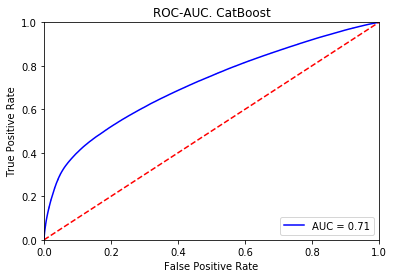

In [78]:
import sklearn.metrics as metrics
probs1 = cat.predict_proba(X_dummy)[:, 1]
fpr1, tpr1, threshold1 = metrics.roc_curve(y, probs1)
roc_auc1 = metrics.auc(fpr1, tpr1)

# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC-AUC. CatBoost')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Делаем предсказание на тесте и загружаем ответы в файл

In [ ]:
X_test=pd.read_csv('X_test.csv').drop('Unnamed: 0',axis=1).fillna('nan')

In [ ]:
X_test.head()

In [ ]:
probas = log.predict_proba(X_test)[:, 1]
df = pd.DataFrame(probas, columns=['Prob'])
df.to_csv('log_submit.csv', index_label='Id')

In [ ]:
probas = cat.predict_proba(X_test)[:, 1]
df = pd.DataFrame(probas, columns=['Prob'])
df.to_csv('cat_submit.csv', index_label='Id')